### Basic pipeline test by creating a very simple version

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from pipeoptz import Pipeline, Node

In [2]:
def add(x, y):
    print(f"add({x}, {y})")
    return x + y

def multiply(a, b):
    print(f"multiply({a}, {b})")
    return a * b

def subtract(x, y):
    print(f"subtract({x}, {y})")
    return x - y

In [3]:
pipeline = Pipeline("Example Pipeline", "This is an example pipeline.")

# Node creation
node_a = Node("A", add, fixed_params={"x": 5, "y": 3}) # A = 5 + 3 = 8
node_b = Node("B", multiply, fixed_params={"b": 10})   # B = A * 10 (A comes from node_a)
node_c = Node("C", subtract, fixed_params={"y": 2})    # C = B - 2 (B comes from node_b)
node_d = Node("D", add, fixed_params={"x": 1})         # D = A + 1 (A comes from node_a)
node_e = Node("E", multiply)                           # E = C * D

# Add nodes to the pipeline with their dependencies
pipeline.add_node(node_a)
pipeline.add_node(node_b, predecessors={"a": "A"})
pipeline.add_node(node_c, predecessors={"x": "B"})
pipeline.add_node(node_d, predecessors={"y": "A"})
pipeline.add_node(node_e, predecessors={"a": "C", "b": "D"})

In [4]:
print("Topological order:", pipeline.static_order())
# Expected: ['A', 'B', 'D', 'C', 'E'] or ['A', 'D', 'B', 'C', 'E'] (depending on the exact implementation of successors)

Topological order: ['A', 'B', 'D', 'C', 'E']


In [5]:
outputs = pipeline.run()
print("Pipeline results:", outputs)
# Expected: {'A': 8, 'B': 80, 'D': 9, 'C': 78, 'E': 702} (the order in the dict may vary)

add(5, 3)
multiply(8, 10)
add(1, 8)
subtract(80, 2)
multiply(78, 9)
Pipeline results: ('E', {'A': 8, 'B': 80, 'D': 9, 'C': 78, 'E': 702}, (0.0005080699920654297, {'A': 0.0003771781921386719, 'B': 4.3392181396484375e-05, 'D': 3.600120544433594e-05, 'C': 2.5272369384765625e-05, 'E': 2.6226043701171875e-05}))


In [6]:
pipeline.to_json("basic.json")
print("Generated .json file.")

Generated .json file.


In [7]:
print("Loading pipeline from JSON and executing:")
loaded_pipeline = Pipeline.from_json("basic.json")
loaded_outputs = loaded_pipeline.run()
print("Pipeline results loaded from JSON:", loaded_outputs)

Loading pipeline from JSON and executing:
add(5, 3)
multiply(8, 10)
add(1, 8)
subtract(80, 2)
multiply(78, 9)
Pipeline results loaded from JSON: ('E', {'A': 8, 'B': 80, 'D': 9, 'C': 78, 'E': 702}, (0.00014543533325195312, {'A': 7.486343383789062e-05, 'B': 2.3603439331054688e-05, 'D': 1.5735626220703125e-05, 'C': 1.5497207641601562e-05, 'E': 1.5735626220703125e-05}))


.dot file.


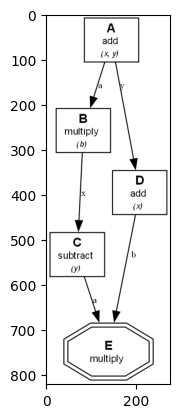

In [8]:
pipeline.to_dot("basic.dot")
print(".dot file.")
pipeline.to_image("basic.png")
plt.imshow(Image.open("basic.png"))

In [9]:
# Cycle test
print("Test with a cycle:")
pipeline_cycle = Pipeline("Cycle Pipeline")
node_x = Node("X", add, {"x":1})
node_y = Node("Y", add, {"x":1})
pipeline_cycle.add_node(node_x, predecessors={"y": "Y"})
pipeline_cycle.add_node(node_y, predecessors={"y": "X"})
try:
    pipeline_cycle.run()
except ValueError as e:
    print(f"Expected error detected: {e}")

Test with a cycle:
Expected error detected: Error preparing the pipeline: The graph contains a cycle, topological sort is impossible.


In [10]:
def tupleOutput():
    return 1, 2

def dictOutput():
    return {"a": 3, "b": 4}

In [11]:
pipe_mo = Pipeline("Multiple Output")

pipe_mo.add_node(Node("Tuple output", tupleOutput))
pipe_mo.add_node(Node("Dict output", dictOutput))
pipe_mo.add_node(Node("Add 1", add), predecessors={"x": "Tuple output:0", "y": "Dict output:a"})
pipe_mo.add_node(Node("Add 2", add), predecessors={"x": "Tuple output:1", "y": "Dict output:b"})
pipe_mo.add_node(Node("Mult", multiply), predecessors={"a": "Add 1", "b": "Add 2"})

In [12]:
outputs = pipe_mo.run()
print(outputs)
print("Pipeline results:", outputs[1][outputs[0]])

add(1, 3)
add(2, 4)
multiply(4, 6)
('Mult', {'Tuple output': (1, 2), 'Dict output': {'a': 3, 'b': 4}, 'Add 1': 4, 'Add 2': 6, 'Mult': 24}, (0.0006248950958251953, {'Tuple output': 1.430511474609375e-05, 'Dict output': 5.0067901611328125e-06, 'Add 1': 0.0005106925964355469, 'Add 2': 5.5789947509765625e-05, 'Mult': 3.910064697265625e-05}))
Pipeline results: 24
